In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

#Random forest
from sklearn.ensemble import RandomForestRegressor

# Library for compare
from sklearn.metrics import r2_score

#Randomized search
from sklearn.model_selection import RandomizedSearchCV

#Gridsearch
from sklearn.model_selection import GridSearchCV

In [3]:
import warnings

warnings.filterwarnings('ignore')

## Read data file

In [4]:
df = pd.read_csv('cars_data.csv')
df = df.drop(['Unnamed: 0'], axis=1)

In [5]:
df['model'] = df['model'].astype('category').cat.codes

In [6]:
df.dropna(axis=0, inplace=True)

#Using always reset index after pd.dropna
df=df.reset_index()


In [7]:
df.head(4)

,index,model,year,Price,EPA Class,Gas Mileage,Engine,Drivetrain,Passenger Capacity,Passenger Doors,Body Style,Maintenance Miles/km,Emissions Note,Transmission
0,0,0,2019,40600.0,67,50.0,150.0,150.0,5,4,150.0,-1,-1,1256
1,1,0,2019,45500.0,67,50.0,150.0,150.0,5,4,150.0,-1,-1,1256
2,2,0,2019,43600.0,67,49.0,150.0,150.0,5,4,150.0,-1,-1,1256
3,3,0,2019,37400.0,67,50.0,150.0,150.0,5,4,150.0,-1,-1,1256


## Details of data

In [8]:
# df.info()

In [9]:
df=df.drop('index', axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26268 entries, 0 to 26267
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   model                 26268 non-null  int8   
 1   year                  26268 non-null  int64  
 2   Price                 26268 non-null  float64
 3   EPA Class             26268 non-null  int64  
 4   Gas Mileage           26268 non-null  float64
 5   Engine                26268 non-null  float64
 6   Drivetrain            26268 non-null  float64
 7   Passenger Capacity    26268 non-null  int64  
 8   Passenger Doors       26268 non-null  int64  
 9   Body Style            26268 non-null  float64
 10  Maintenance Miles/km  26268 non-null  int64  
 11  Emissions Note        26268 non-null  int64  
 12  Transmission          26268 non-null  int64  
dtypes: float64(5), int64(7), int8(1)
memory usage: 2.4 MB


In [11]:
X = df.copy(deep=True)
y = df.Price

In [12]:
X=X.drop('Price', axis=1)

In [13]:
#on tranforme y en array pour travailler avec le modele de ML
y=pd.DataFrame(y)

## Machine Learning

In [14]:
#Train split test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

##  Random Forest Regressor

#### Parameters

In [16]:
rf = RandomForestRegressor()

#parameters for randomized search and grid search
n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=10)]
max_features = [None, 'auto', 'sqrt']
max_depth = [14, 18]
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

In [17]:
print(param_grid)

{'n_estimators': [100, 111, 122, 133, 144, 155, 166, 177, 188, 200], 'max_features': [None, 'auto', 'sqrt'], 'max_depth': [14, 18], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


## Randomized Search CV

In [18]:
rds = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, verbose=3,
n_jobs=-1, return_train_score=True, scoring="r2")

#values.ravel is used to arrange the array
# rds will substitute rf in the fit
rds.fit(X_train, y_train.values.ravel())

print("The best parameters  :", rds.best_params_)

# It is to recover the best algorithm found by randomized search
model = rds.best_estimator_

model.fit(X_train, y_train.values.ravel())

predict_price_test=rds.predict(X_test)
predict_price_train=rds.predict(X_train)

#Compare y_test(reals values) against predicted price values on X_test
print("r2 score test :", r2_score(y_test, predict_price_test))

#the big difference between the R2 test and train, that means we over fit the model
print("r2 score train :", r2_score(y_train, predict_price_train))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best parameters  : {'n_estimators': 188, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 18, 'bootstrap': False}
r2 score test : 0.9635002634366892
r2 score train : 0.990595627915352


## Grid Search CV

In [19]:
gs = GridSearchCV(estimator=rf, param_grid=param_grid, verbose=3,
n_jobs=2, return_train_score=True, scoring="r2")

gs.fit(X_train, y_train.values.ravel())

print("The best parameters :", gs.best_params_)

model = gs.best_estimator_

model.fit(X_train, y_train.values.ravel())

predict_price_test=gs.predict(X_test)
predict_price_train=gs.predict(X_train)

print("r2 score test :", r2_score(y_test, predict_price_test))
print("r2 score train :", r2_score(y_train, predict_price_train))

## K Fold

In [20]:

# Split the data into 5 folds.
# We will use this 'kf'(KFold splitting strategy) object as input to cross_val_score() method
kf =KFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestRegressor()

n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=10)]
print("n_estimators :", n_estimators)
max_features = [None, 'auto', 'sqrt']
max_depth = [10, 14, 18]
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

n_estimators : [100, 111, 122, 133, 144, 155, 166, 177, 188, 200]


## Randomized Search CV (kFold)

In [21]:
rsf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, verbose=3,
n_jobs=-1, return_train_score=True, scoring="r2", cv=kf)

rsf.fit(X_train, y_train.values.ravel())

print("The best parameters :", rsf.best_params_)

model = rsf.best_estimator_

model.fit(X_train, y_train.values.ravel())

predict_price_test=rsf.predict(X_test)
predict_price_train=rsf.predict(X_train)

print("r2 score test :", r2_score(y_test, predict_price_test))

print("r2 score train :", r2_score(y_train, predict_price_train))

print('\n')

score = cross_val_score(model, X_train, y_train.values.ravel(), cv=kf, scoring="r2")
print("Kfold score mean :", score.mean() * 100.0)
print("Kfold std deviation :", score.std() * 100.0)
print("Kfold accuracy for each kfold :", score)
print("Kfold variance :", score.var())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best parameters : {'n_estimators': 166, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 18, 'bootstrap': True}
r2 score test : 0.9587936018277113
r2 score train : 0.9843813631308301


Kfold score mean : 93.6180174277052
Kfold std deviation : 1.2996742902511158
Kfold accuracy for each kfold : [0.94004127 0.93730947 0.91119167 0.94759439 0.94476407]
Kfold variance : 0.00016891532607397417


## Grid Search CV (KFold)

In [22]:

gsf = GridSearchCV(estimator=rf, param_grid=param_grid, verbose=3,
n_jobs=2, return_train_score=True, scoring="r2")

gsf.fit(X_train, y_train.values.ravel())

print("The best parameters :", gsf.best_params_)

model = gsf.best_estimator_

model.fit(X_train, y_train.values.ravel())

predict_price_test=gsf.predict(X_test)
predict_price_train=gsf.predict(X_train)

print("r2 score test :", r2_score(y_test, predict_price_test))

print("r2 score train :", r2_score(y_train, predict_price_train))

print('\n')

score = cross_val_score(model, X_train, y_train.values.ravel(), cv=kf, scoring="r2")
print("Kfold score mean :", score.mean() * 100.0)
print("Kfold std deviation :", score.std() * 100.0)
print("Kfold accuracy for each kfold :", score)
print("Kfold variance :", score.var())

## Show the Feature Importance

Text(0.5, 0, 'Relative Importance')

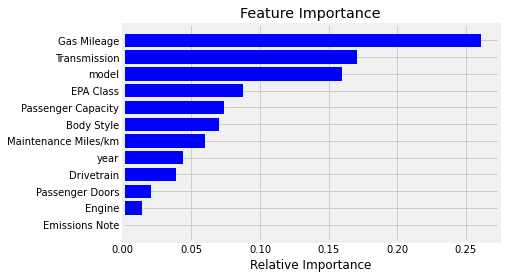

In [23]:
list_variables=list(X.columns)
importance = model.feature_importances_ # info given by random forest
indices = np.argsort(importance)
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.figure(1)
plt.title('Feature Importance')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [list_variables[i] for i in indices])
plt.xlabel('Relative Importance')
